In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [22]:
import channelparams
from shooting import *
from theory import *

In [23]:
fbc = channelparams.fbc.copy()
r = fbc['rsill']

In [24]:
def shoot_2d(α, r, nx=50, nβ=100, nγ=100):
    βs = np.logspace(-0.75, np.log10(3), num=nβ) #np.linspace(1e-3, 1., nβ)
    γs = np.logspace(-1.5, np.log10(3**2), num=nγ) #np.linspace(1e-3, 1., nγ)
    
    match = np.zeros((nγ, nβ))
    Q = np.zeros((nγ, nβ))
    for jj, β in enumerate(βs):
        for kk, γ in enumerate(γs):
            outputs = shoot_perturbations(α, β, γ, r, nx)
            match[kk,jj] = outputs['match']
            Q[kk,jj] = outputs['Q']
            
            
    outputs = {
        "βs": βs,
        "γs": γs,
        "match": match,
        "Q": Q,
    }
    return outputs

In [25]:
def plot_interface(ax, α, β, γ, r, nx = 200):
    xL = (-β+np.sqrt(β**2 - 4*α*γ))/(2*α)
    xR = (-β-np.sqrt(β**2 - 4*α*γ))/(2*α)
    w = xR-xL

    xm = np.maximum(np.abs(xL), np.abs(xR)) + w/10
    dx = 2*xm/nx

    x = np.arange(-xm, xm+dx, dx)

    h = x**2/r
    d = α*x**2 + β*x + γ
    η = d+h
    η[d<0.] = np.nan
    d[d<0.] = np.nan

    z = np.linspace(0., np.nanmax(η), 100)[np.newaxis, :]
    v = (2.*(α + 1/r)*x + β)[:, np.newaxis]

    xx = np.tile(x[:, np.newaxis], (1, z.size))
    zz = np.tile(z, (x.size, 1))
    vv = np.tile(v, (1, z.size))
    vv[np.logical_not(np.logical_and(zz > h[:, np.newaxis], zz < η[:, np.newaxis]))] = np.nan
    ax.pcolor(xx, zz, vv, cmap="RdBu_r", vmin=-np.nanmax(np.abs(v)), vmax=np.nanmax(np.abs(v)))

    ax.plot(x, h, color="Grey", lw=2)
    ax.plot(x, η, "k-", lw=2)

    ax.set_ylim(-np.max(h)/30, np.max(h))
    return

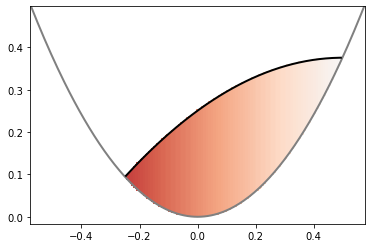

In [26]:
α_zpv = -0.5*(1.+2./r)
ax = plt.subplot()
plot_interface(ax, α_zpv, 0.5, γ_zpv(0.5, r), r)

In [73]:
α_vpv = α_zpv+0.95*(-1/r - α_zpv)

outputs = {
    "zpv": shoot_2d(α_zpv, r),
    "vpv": shoot_2d(α_vpv, r)
}
    
zpv = outputs['zpv']
βs = zpv["βs"]
γs = zpv["γs"]
match = zpv["match"]
Q = zpv["Q"]

tol = 0.1
controlled = (match < tol).astype(np.float64)
controlled[controlled==0]=np.nan

idx = np.where(~np.isnan(controlled))

### Zero-PV regime diagram


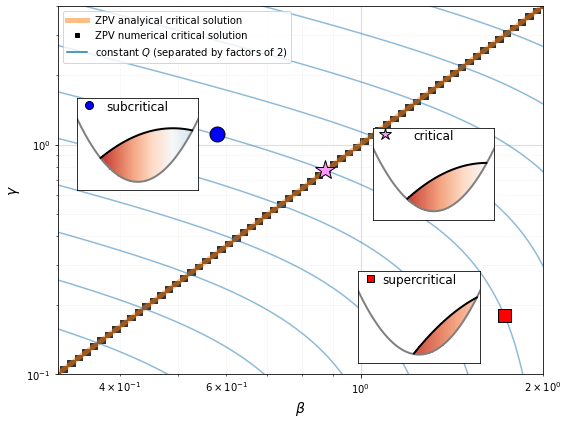

In [74]:
plt.figure(figsize=(8, 6))

v = outputs["zpv"]

βs = v["βs"]
γs = v["γs"]
match = v["match"]
Q = v["Q"]

tol = 0.1
controlled = np.logical_and(match> -tol, match< tol).astype(np.float64)
controlled[controlled==0]=np.nan

ax = plt.subplot()
ax.pcolor(βs, γs, controlled, cmap="Greys", vmin=0, vmax=1.2, alpha=1.)

ax.plot(βs, γ_zpv(βs, r), "C1-", lw=5, alpha=0.5, label="ZPV analyical critical solution")
ax.plot([], [], "ks", markersize=3.5, label="ZPV numerical critical solution")
ax.plot([], [], "C0-", label=r"constant $Q$ (separated by factors of 2)")
ax.set_xlim(10**(-0.5), 2)
ax.set_ylim(10**(-1), 2**2)

cs = ax.contour(βs, γs, Q, levels=2.**np.arange(-6., 5., 1.), linestyles="-", colors="C0", alpha=0.5)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$β$", fontsize=14)
ax.set_ylabel(r"$γ$", fontsize=14)
ax.grid(True, which="minor", alpha=0.1)
ax.grid(True, which="major", alpha=0.4, lw=1.2)
ax.legend()

# super critical
β, γ = 5.8e-1, 1.115
# ax.plot([β, β-0.06], [γ, γ+0.55], "k-")
# ax.plot([β, β-0.06], [γ, γ-0.45], "k-")
ax.plot(β, γ, "o", color=(0,0,1), markersize=15, markeredgecolor="k")
axins = ax.inset_axes([0.04, 0.5, 0.25, 0.25])
plot_interface(axins, α_zpv, β, γ, r)
axins.plot([], [], "o", color=(0,0,1), markersize=8, markeredgecolor="k", label=" ")
axins.legend(frameon=False, loc="upper left", borderpad=0, labelspacing=0., borderaxespad=0.2)
axins.set_xticks([])
axins.set_yticks([])
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_title("subcritical", fontsize=12, y=0.805)
axins.set_ylim(-0.2, 2.)
axins.set_xlim(-1, 1)

# critical
β, γ = 8.75e-1, 0.775
ax.plot()
ax.plot(β, γ, "*", color=(1.,0.6,1.), markersize=20, markeredgecolor="k")
axins = ax.inset_axes([0.65, 0.42, 0.25, 0.25])
plot_interface(axins, α_zpv, β, γ, r)
axins.plot([], [], "*", color=(1,0.6,1), markersize=12, markeredgecolor="k", label=" ")
axins.legend(frameon=False, loc="upper left", borderpad=0, labelspacing=0., borderaxespad=0.2)
axins.set_xticks([])
axins.set_yticks([])
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_title("critical", fontsize=12, y=0.805)
axins.set_ylim(-0.2, 2.)
axins.set_xlim(-1, 1)

# subcritical
β, γ = 1.725, 0.18
ax.plot(β, γ, "s", color=(1,0,0), markersize=13, markeredgecolor="k")
axins = ax.inset_axes([0.62, 0.03, 0.25, 0.25])
plot_interface(axins, α_zpv, β, γ, r)
axins.plot([], [], "s", color=(1,0,0), markersize=7, markeredgecolor="k", label=" ")
axins.legend(frameon=False, loc="upper left", borderpad=0, labelspacing=0., borderaxespad=0.2)
axins.set_xticks([])
axins.set_yticks([])
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_title("supercritical", fontsize=12, y=0.805)
axins.set_ylim(-0.2, 2.)
axins.set_xlim(-1, 1)

plt.tight_layout()

### Variable PV diagram

In [106]:
vpv = outputs['vpv']
βs = vpv["βs"]
γs = vpv["γs"]
match = vpv["match"]
Q = vpv["Q"]

tol = 0.1
controlled = (match < tol).astype(np.float64)
controlled[controlled==0]=np.nan

idx = np.where(~np.isnan(controlled))

In [109]:
α = α_vpv
nx = 100


βis = np.zeros(len(idx[0]))
γis = np.zeros(len(idx[0]))
Qis = np.zeros(len(idx[0]))

βfs = np.zeros(len(idx[0]))
γfs = np.zeros(len(idx[0]))
Qfs = np.zeros(len(idx[0]))

for ii, (i, j) in enumerate(zip(idx[1], idx[0])):
    
    β=βs[i]
    γ=γs[j]
    
    βis[ii] = β
    γis[ii] = γ
    
    xL = (-β+np.sqrt(β**2 - 4*α*γ))/(2*α)
    xR = (-β-np.sqrt(β**2 - 4*α*γ))/(2*α)
    
    dx = (xR-xL)/nx
    x = np.arange(xL, xR+dx, dx)
    d = α*x**2 + β*x + γ
    h = x**2/r
    Q = np.nansum(np.diff(d+h)*(d[1:]+d[:-1])/2.*dx)
    Qis[ii] = Q
    
    βf, γf = np.polyfit(x, d-(α_zpv*x**2), 1)
    
    xLf = (-β+np.sqrt(β**2 - 4*α*γ))/(2*α)
    xRf = (-β-np.sqrt(β**2 - 4*α*γ))/(2*α)
    
    dxf = (xRf-xLf)/nx
    xf = np.arange(xLf, xRf+dxf, dxf)
    
    df = α_zpv*xf**2 + βf*xf + γf
    df[df<0] = np.nan
    
    hf = xf**2/r
    Qf = np.nansum(np.diff(df+hf)*(df[1:]+df[:-1])/2.*dx)
    
    βfs[ii] = βf
    γfs[ii] = γf
    Qfs[ii] = Qf

In [195]:
spec

GridSpec(1, 3)

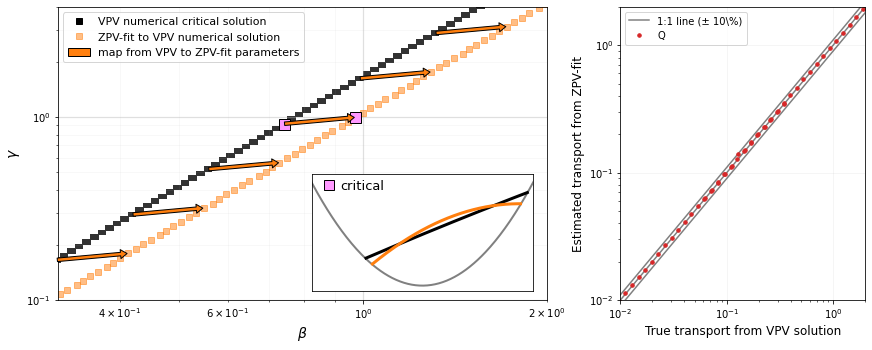

In [238]:
fig = plt.figure(figsize=(12, 4.75), constrained_layout=True)
spec = fig.add_gridspec(1, 3)

ax = fig.add_subplot(spec[0, 0:2])

v = outputs["vpv"]

βs = v["βs"]
γs = v["γs"]
match = v["match"]
Q = v["Q"]

tol = 0.1
controlled = np.logical_and(match> -tol, match< tol).astype(np.float64)
controlled[controlled==0]=np.nan

ax.pcolor(βs, γs, controlled, cmap="Greys", vmin=0, vmax=1.2, alpha=1.)
l1 = ax.plot([], [], "ks", markersize=6.8, label="VPV numerical critical solution")
l2 = ax.plot(βfs, γfs, "C1s", markersize=6.8, alpha=0.5, label="ZPV-fit to VPV numerical solution")

ax.set_xlim(10**(-0.5), 2)
ax.set_ylim(10**(-1), 2**2)

for ii, (i, j) in enumerate(zip(idx[1], idx[0])):
    if not(ii%10):
        an = ax.annotate(
            '', xy=(βfs[ii], γfs[ii]),  xycoords='data',
            xytext=(βs[i], γs[j]), textcoords='data',
            arrowprops=dict(facecolor='C1', shrink=0.0125, width=3.5, headlength=6.5, headwidth=9, edgecolor="k", linewidth=1.),
            label = "map from VPV to ZPV-fit parameters"
        )
ax.legend([l1[0], l2[0], an.arrow_patch], [l1[0].get_label(), l2[0].get_label(), an.get_label()], fontsize=11)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$β$", fontsize=14)
ax.set_ylabel(r"$γ$", fontsize=14)
ax.grid(True, which="minor", alpha=0.1)
ax.grid(True, which="major", alpha=0.4, lw=1.2)

# critical
nx = 250
ii = 50
axins = ax.inset_axes([0.52, 0.03, 0.45, 0.4])

# VPV numerical solution
α = α_vpv
β = βis[ii]
γ = γis[ii]
ax.plot(β, γ, "s", color=(1,0.6,1), markersize=11, markeredgecolor="k")

xL = (-β+np.sqrt(β**2 - 4*α*γ))/(2*α)
xR = (-β-np.sqrt(β**2 - 4*α*γ))/(2*α)
w = xR-xL

xm = np.maximum(np.abs(xL), np.abs(xR)) + w/10
dx = 2*xm/nx

x = np.arange(-xm, xm+dx, dx)

h = x**2/r
d = α*x**2 + β*x + γ
η = d+h
η[d<0.] = np.nan
d[d<0.] = np.nan

z = np.linspace(0., np.nanmax(η), 100)[np.newaxis, :]
v = (2.*(α + 1/r)*x + β)[:, np.newaxis]

xx = np.tile(x[:, np.newaxis], (1, z.size))
zz = np.tile(z, (x.size, 1))
vv = np.tile(v, (1, z.size))
vv[np.logical_not(np.logical_and(zz > h[:, np.newaxis], zz < η[:, np.newaxis]))] = np.nan

axins.plot(x, h, color="Grey", lw=2)
axins.plot(x, η, "k-", lw=3)

# ZPV-fit to VPV numerical solution
α = α_zpv
β = βfs[ii]
γ = γfs[ii]
ax.plot(β, γ, "s", color=(1,0.6,1), markersize=11, markeredgecolor="k")

xL = (-β+np.sqrt(β**2 - 4*α*γ))/(2*α)
xR = (-β-np.sqrt(β**2 - 4*α*γ))/(2*α)
w = xR-xL

xm = np.maximum(np.abs(xL), np.abs(xR)) + w/10
dx = 2*xm/nx

x = np.arange(-xm, xm+dx, dx)

h = x**2/r
d = α*x**2 + β*x + γ
η = d+h
η[d<0.] = np.nan
d[d<0.] = np.nan

z = np.linspace(0., np.nanmax(η), 100)[np.newaxis, :]
v = (2.*(α + 1/r)*x + β)[:, np.newaxis]

xx = np.tile(x[:, np.newaxis], (1, z.size))
zz = np.tile(z, (x.size, 1))
vv = np.tile(v, (1, z.size))
vv[np.logical_not(np.logical_and(zz > h[:, np.newaxis], zz < η[:, np.newaxis]))] = np.nan

axins.plot(x, η, "C1-", lw=3)

axins.plot([], [], "s", color=(1,0.6,1), markersize=10, markeredgecolor="k", label=" ")
axins.legend(frameon=False, loc="upper left", borderpad=0.5, labelspacing=0., borderaxespad=0.2)
axins.set_xticks([])
axins.set_yticks([])
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_title("critical", fontsize=13, y=0.815, x=0.225)
axins.set_ylim(-0.1, 2.)
axins.set_xlim(-1.1, 1.1)

ax1 = fig.add_subplot(spec[0, 2])
ax1.loglog(np.array([1e-5, 3]), np.array([1e-5, 3]), "k-", alpha=0.5)
ax1.loglog(np.array([1e-5, 3]), np.array([1e-5, 3])*1.1, "k-", alpha=0.5)
ax1.loglog(np.array([1e-5, 3]), np.array([1e-5, 3])*0.9, "k-", alpha=0.5, label="1:1 line (± 10\%)")
ax1.loglog(Qis, Qfs, "C3.", alpha=1., label="Q", markersize=7)
ax1.grid(True, alpha=0.15)
ax1.set_xlim(1e-2, 2e0)
ax1.set_ylim(1e-2, 2e0)
ax1.set_xlabel("True transport from VPV solution", fontsize=12)
ax1.set_ylabel("Estimated transport from ZPV-fit", fontsize=12)
ax1.legend()